In [1]:
import os
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

torch.manual_seed(17)

## Download dataset 
https://drive.google.com/drive/folders/1vI8Bkk5DojitLNkpz-UT30jOEay0XXon?usp=sharing

In [2]:
# parameters
BATCH_SIZE = 128
mini_batch = 100
num_workers = 8
gpu_idx = 1
# 'simple_net', 'resnet', 'wide_resnet', 'efficientnet'
model_use = 'wide_resnet'
EPOCH = 20
PATH = './cifar_wide_resnet_ep20_v2.pth'

## Load data

In [3]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")

x_test = np.load("x_test.npy")
y_test = np.load("y_test.npy")

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

50000 train samples
10000 test samples


In [4]:
# It's a multi-class classification problem 
class_index = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat',4: 'deer',
               5: 'dog',6: 'frog',7: 'horse',8: 'ship',9: 'truck'}
print(np.unique(y_train, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))


![image](https://img-blog.csdnimg.cn/20190623084800880.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3lqcDE5ODcxMDEz,size_16,color_FFFFFF,t_70)

## Data preprocess

In [5]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

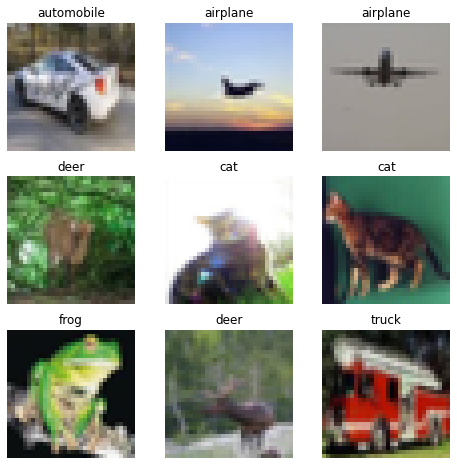

In [6]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(x_train), size=(1,)).item()
    img = x_train[sample_idx]
    label = y_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    
    plt.title(class_index[int(label)])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Dataset

In [7]:
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split

tensor_x_train = torch.Tensor(x_train).permute(0, 3, 1, 2) # transform to torch tensor
tensor_y_train = torch.Tensor(y_train).squeeze()
tensor_x_test = torch.Tensor(x_test).permute(0, 3, 1, 2)
tensor_y_test = torch.Tensor(y_test).squeeze()

training_data = TensorDataset(tensor_x_train, tensor_y_train)
test_data = TensorDataset(tensor_x_test, tensor_y_test)

# Random split
train_set_size = int(len(training_data) * 0.8)
valid_set_size = len(training_data) - train_set_size
training_data, valid_data = random_split(training_data, [train_set_size, valid_set_size])

trainloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
validloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

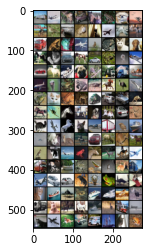

truck airplane deer  automobile horse frog  dog   airplane deer  bird  ship  frog  cat   airplane horse horse truck frog  cat   airplane bird  frog  cat   dog   horse cat   truck horse automobile frog  dog   airplane automobile horse ship  dog   bird  truck truck ship  airplane bird  frog  frog  bird  horse bird  airplane frog  cat   frog  frog  truck truck automobile frog  horse airplane horse truck dog   cat   automobile deer  cat   airplane horse dog   airplane truck bird  ship  airplane cat   deer  horse automobile deer  bird  horse bird  cat   airplane frog  horse deer  dog   airplane truck dog   ship  frog  airplane cat   deer  truck airplane automobile automobile dog   frog  frog  airplane airplane cat   ship  airplane cat   ship  ship  bird  bird  truck horse deer  horse ship  deer  truck ship  horse airplane dog   automobile truck ship  cat   frog 


In [8]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
#print(labels)
# print labels
print(' '.join(f'{class_index[int(labels[j])]:5s}' for j in range(BATCH_SIZE)))

In [9]:
torch.cuda.is_available()

True

In [10]:
device = torch.device("cuda:"+str(gpu_idx) if torch.cuda.is_available() else "cpu")
print(device)

cuda:1


In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


if model_use == 'simple_net':
    net = Net()
    print(net)
elif model_use == 'resnet':
    # resnet
    net = models.resnet18(pretrained=True)
    print(net)
    num_ftrs = net.fc.in_features
    net.fc = nn.Linear(num_ftrs, 10)
elif model_use == 'wide_resnet':
    net = models.wide_resnet101_2(pretrained=True)
    print(net)
    num_ftrs = net.fc.in_features
    net.fc = nn.Linear(num_ftrs, 10)
elif model_use == 'efficientnet':
    net = models.efficientnet_b7(pretrained=True)
    print(net)
    num_ftrs = net.classifier[1].in_features
    net.fc = nn.Linear(num_ftrs, 10)
else:
    raise Exception('wrong model name')


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [12]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-3)

In [13]:
net = net.to(device)

## Training

In [14]:
# Transform
trans = torch.nn.Sequential(
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomAffine(30)
)
scripted_transforms = torch.jit.script(trans)

In [15]:
def cal_correct(dataloader):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device=device)
            labels = labels.to(device=device, dtype=torch.int64)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct // total

0it [00:00, ?it/s]

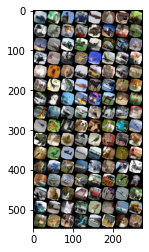

ship  bird  bird  automobile airplane cat   frog  deer  truck dog   cat   ship  dog   truck truck deer  airplane airplane truck horse ship  automobile automobile deer  deer  airplane airplane frog  airplane airplane truck dog   cat   dog   cat   automobile automobile frog  truck deer  horse cat   frog  airplane horse ship  deer  cat   automobile dog   ship  ship  truck horse deer  deer  ship  truck ship  ship  bird  cat   automobile cat   airplane frog  cat   dog   cat   dog   truck airplane frog  bird  frog  truck bird  frog  horse cat   airplane bird  airplane ship  ship  horse deer  truck dog   truck horse ship  deer  deer  cat   airplane bird  frog  automobile airplane ship  truck bird  dog   airplane cat   cat   truck automobile horse airplane automobile automobile truck cat   automobile bird  dog   airplane truck deer  frog  horse bird  ship  deer  dog   frog 
Accuracy of the network on the train images: 41 %
Accuracy of the network on the valid images: 40 %
[1,   100] loss: 2.03

0it [00:00, ?it/s]

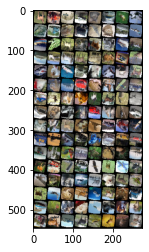

horse truck cat   ship  cat   ship  frog  airplane frog  truck bird  truck airplane cat   ship  airplane ship  frog  horse bird  dog   truck ship  horse ship  airplane horse horse horse frog  automobile deer  automobile cat   ship  truck cat   automobile ship  horse dog   cat   ship  automobile frog  horse airplane truck dog   deer  dog   horse cat   horse bird  ship  automobile dog   airplane dog   automobile bird  bird  automobile horse horse horse dog   cat   automobile truck airplane truck airplane ship  truck frog  automobile automobile automobile ship  dog   bird  horse frog  frog  deer  ship  frog  truck truck automobile bird  deer  airplane horse airplane frog  ship  ship  airplane dog   horse frog  deer  airplane frog  deer  ship  horse cat   truck airplane deer  dog   cat   airplane truck dog   bird  truck horse airplane horse bird  deer  bird  dog  
Accuracy of the network on the train images: 66 %
Accuracy of the network on the valid images: 63 %
[2,   100] loss: 1.204
Accu

0it [00:00, ?it/s]

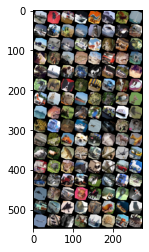

airplane dog   horse ship  airplane airplane deer  ship  airplane truck truck ship  bird  airplane bird  frog  truck airplane ship  automobile dog   frog  cat   cat   horse deer  truck frog  deer  truck frog  ship  cat   airplane dog   automobile dog   airplane automobile deer  bird  horse dog   deer  automobile truck dog   dog   truck ship  frog  ship  frog  deer  bird  bird  ship  frog  deer  horse bird  truck ship  bird  frog  truck deer  ship  deer  automobile frog  cat   ship  frog  truck dog   automobile cat   horse airplane horse deer  frog  frog  truck airplane airplane airplane cat   bird  frog  horse truck bird  automobile horse automobile automobile truck truck dog   ship  truck bird  airplane deer  airplane dog   horse ship  bird  airplane automobile automobile airplane bird  deer  bird  ship  bird  airplane ship  horse horse ship  frog  truck bird 
Accuracy of the network on the train images: 73 %
Accuracy of the network on the valid images: 69 %
[3,   100] loss: 0.973
Acc

In [16]:
from tqdm.notebook import tqdm
import logging

logging.basicConfig(level=logging.INFO, filename='log.txt', filemode='a',
	format='[%(asctime)s %(levelname)-8s] %(message)s',
	datefmt='%Y%m%d %H:%M:%S',
	)

acc_max = -1

#net.train()
for epoch in range(EPOCH):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in tqdm(enumerate(trainloader, 0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = scripted_transforms(inputs)
        if i==0:
            imshow(torchvision.utils.make_grid(inputs))
            print(' '.join(f'{class_index[int(labels[j])]:5s}' for j in range(BATCH_SIZE)))
        inputs = inputs.to(device=device, dtype=torch.float)
        labels = labels.to(device=device, dtype=torch.int64)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % mini_batch == (mini_batch - 1):
            ans_train = cal_correct(trainloader)
            print(f'Accuracy of the network on the train images: {ans_train} %')
            logging.info(f'Accuracy of the network on the train images: {ans_train} %')
            
            ans_val = cal_correct(validloader)
            print(f'Accuracy of the network on the valid images: {ans_val} %')
            logging.info(f'Accuracy of the network on the valid images: {ans_val} %')

            if ans_val > acc_max:
                torch.save(net.state_dict(), PATH)
                acc_max = ans_val
            
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / mini_batch:.3f}')
            logging.info(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / mini_batch:.3f}')
            running_loss = 0.0

print('Finished Training')

In [ ]:
torch.save(net.state_dict(), PATH)

## End Training

In [ ]:
net.load_state_dict(torch.load(PATH))

ans = cal_correct(testloader)
print(f'Accuracy of the network on the 10000 test images: {ans} %')
logging.info(f'{PATH}: Accuracy of the network on the 10000 test images: {ans} %')

Accuracy of the network on the 10000 test images: 80 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in list(class_index.keys())}
total_pred = {classname: 0 for classname in list(class_index.keys())}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device=device)
        labels = labels.to(device=device, dtype=torch.int64)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[int(label)] += 1
            total_pred[int(label)] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {class_index[classname]:5s} is {accuracy:.1f} %')



Accuracy for class: airplane is 83.4 %
Accuracy for class: automobile is 90.0 %
Accuracy for class: bird  is 78.3 %
Accuracy for class: cat   is 64.9 %
Accuracy for class: deer  is 75.1 %
Accuracy for class: dog   is 70.0 %
Accuracy for class: frog  is 86.3 %
Accuracy for class: horse is 82.5 %
Accuracy for class: ship  is 87.6 %
Accuracy for class: truck is 87.1 %


In [ ]:
# convert to .py file

import sys
import json
base_dir = os.getcwd()
print(base_dir)

of_file = os.path.join('log/', str(__file__).replace('.ipynb', '_'+PATH+'.py'))
f = open(__file__, 'r')  # input.ipynb
j = json.load(f)
of = open(of_file, 'w')  # output.py

if j["nbformat"] >= 4:
    for i, cell in enumerate(j["cells"]):
        of.write("#cell "+str(i)+"\n")
        for line in cell["source"]:
            of.write(line)
        of.write('\n\n')
else:
    for i, cell in enumerate(j["worksheets"][0]["cells"]):
        of.write("#cell "+str(i)+"\n")
        for line in cell["input"]:
            of.write(line)
        of.write('\n\n')

of.close()


NameError: name '__file__' is not defined

Ref: <br>
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html <br>
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html <br>
https://pytorch.org/vision/0.9/transforms.html <br>

## DO NOT MODIFY CODE BELOW!
**Please screen shot your results and post it on your report**

In [ ]:
y_pred = your_model.predict(x_test)

NameError: name 'your_model' is not defined

In [ ]:
assert y_pred.shape == (10000,)

In [ ]:
y_test = np.load("y_test.npy")
print("Accuracy of my model on test set: ", accuracy_score(y_test, y_pred))